Import Libraries


In [ ]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array


Set Paths and Configurations

In [ ]:
BASE_DIR = "/content/Final_Preprocessed_Dataset"  # Change if needed
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
RANDOM_STATE = 42

RESULTS_CSV = "rf_cnn_results_tealeaf.csv"
BEST_MODEL_FILE = "rf_best_model_tealeaf.pkl"
ALL_MODELS_DIR = "saved_rf_models"
os.makedirs(ALL_MODELS_DIR, exist_ok=True)

# Check folders
for p in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(p, "exists?", os.path.exists(p))


/content/Final_Preprocessed_Dataset/train exists? True
/content/Final_Preprocessed_Dataset/val exists? True
/content/Final_Preprocessed_Dataset/test exists? True


Image Data Generators

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=16, class_mode='categorical', shuffle=False)
val_gen   = datagen.flow_from_directory(VAL_DIR,   target_size=IMG_SIZE, batch_size=16, class_mode='categorical', shuffle=False)
test_gen  = datagen.flow_from_directory(TEST_DIR,  target_size=IMG_SIZE, batch_size=16, class_mode='categorical', shuffle=False)

class_indices = train_gen.class_indices
class_labels = list(class_indices.keys())
NUM_CLASSES = len(class_labels)

print("Detected classes:", class_indices)
print("Train:", train_gen.samples, "Val:", val_gen.samples, "Test:", test_gen.samples)


Found 2000 images belonging to 5 classes.
Found 298 images belonging to 5 classes.
Found 597 images belonging to 5 classes.
Detected classes: {'1. Tea algal leaf spot': 0, '2. Brown Blight': 1, '4. Helopeltis': 2, '5. Red spider': 3, '7. Healthy leaf': 4}
Train: 2000 Val: 298 Test: 597


Feature Extraction Using VGG16

In [ ]:
cnn_base = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
cnn_base.trainable = False

def extract_features_from_generator(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features_from_generator(train_gen, cnn_base)
val_features, val_labels     = extract_features_from_generator(val_gen, cnn_base)
test_features, test_labels   = extract_features_from_generator(test_gen, cnn_base)

# Flatten features
X_train = train_features.reshape(train_features.shape[0], -1)
X_val   = val_features.reshape(val_features.shape[0], -1)
X_test  = test_features.reshape(test_features.shape[0], -1)

y_train = train_labels
y_val   = val_labels
y_test  = test_labels

print("Feature shapes:", X_train.shape, X_val.shape, X_test.shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 1172s 9s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 174s 9s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 348s 9s/step
Feature shapes: (2000, 512) (298, 512) (597, 512)


Train a single RF model directly

In [ ]:
rf_variants = {
    "Option 1": RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    "Option 2": RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=2, min_samples_leaf=1, random_state=42, n_jobs=-1),
    "Option 3": RandomForestClassifier(n_estimators=250, max_depth=25, min_samples_split=2, min_samples_leaf=2, random_state=42, n_jobs=-1)
}

from sklearn.metrics import accuracy_score, f1_score
import joblib

variant_results = []

for name, model in rf_variants.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Validation
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    print(f"{name} - Validation Accuracy: {acc:.4f}, F1: {f1:.4f}")

    # Save model
    fn = os.path.join(ALL_MODELS_DIR, f"rf_{name.replace(' ', '_')}.pkl")
    joblib.dump(model, fn)

    variant_results.append({"variant": name, "val_acc": acc, "val_f1": f1, "saved_model": fn})

# Pick best model based on validation accuracy
best_variant = max(variant_results, key=lambda r: r["val_acc"])
print("\nBest variant based on validation accuracy:", best_variant["variant"])
chosen_model = joblib.load(best_variant["saved_model"])



Training Option 1...
Option 1 - Validation Accuracy: 0.6980, F1: 0.6946

Training Option 2...
Option 2 - Validation Accuracy: 0.6946, F1: 0.6858

Training Option 3...
Option 3 - Validation Accuracy: 0.6779, F1: 0.6685

Best variant based on validation accuracy: Option 1


Evaluate on Test Set


TEST Accuracy: 0.6918
TEST F1: 0.6823


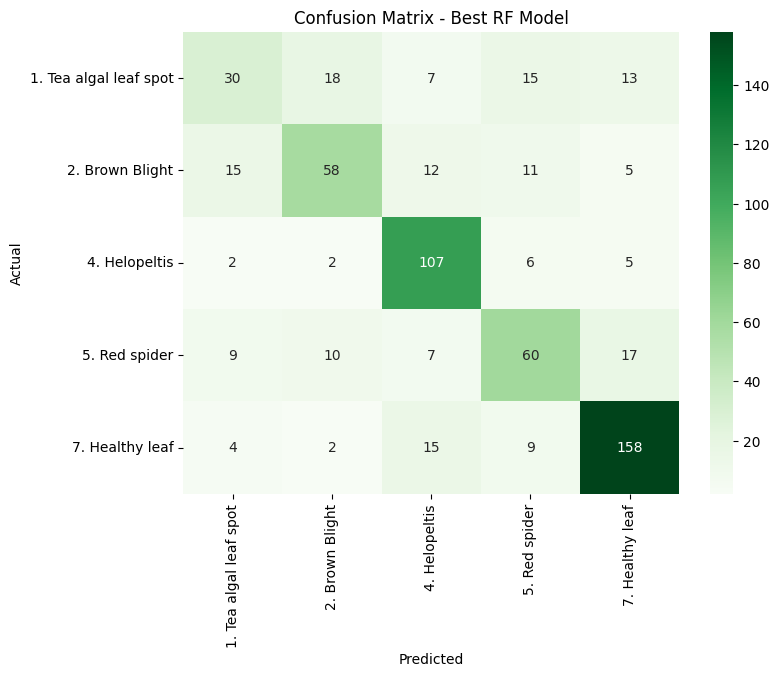


Classification Report:
                         precision    recall  f1-score   support

1. Tea algal leaf spot       0.50      0.36      0.42        83
       2. Brown Blight       0.64      0.57      0.61       101
         4. Helopeltis       0.72      0.88      0.79       122
         5. Red spider       0.59      0.58      0.59       103
       7. Healthy leaf       0.80      0.84      0.82       188

              accuracy                           0.69       597
             macro avg       0.65      0.65      0.65       597
          weighted avg       0.68      0.69      0.68       597



In [ ]:
y_test_pred = chosen_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\nTEST Accuracy: {test_acc:.4f}")
print(f"TEST F1: {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best RF Model")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=class_labels))


5-Fold Cross-Validation on Training Set

5-Fold CV Accuracy for chosen model: [0.575  0.5025 0.595  0.56   0.55  ]
Mean CV Accuracy: 0.5565
Std CV Accuracy: 0.03096772513440405


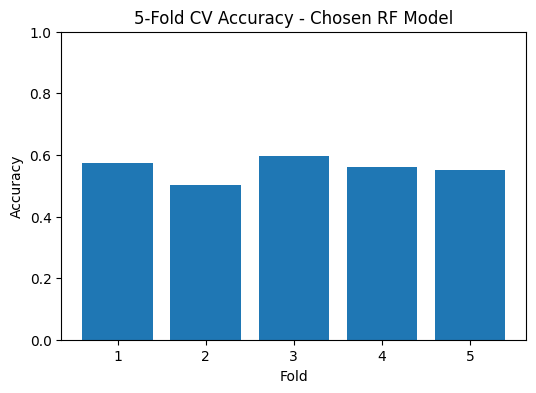

In [ ]:
from sklearn.model_selection import cross_val_score

# 5-Fold CV on training features for the chosen model
cv_scores = cross_val_score(chosen_model, X_train, y_train, cv=5, scoring='accuracy')

print("5-Fold CV Accuracy for chosen model:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Std CV Accuracy:", cv_scores.std())

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(range(1,6), cv_scores)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("5-Fold CV Accuracy - Chosen RF Model")
plt.ylim(0,1)
plt.show()
